<a href="https://colab.research.google.com/github/sandeeepmedepalli/ml-colony-classification/blob/main/colab_code/updated_100__enhanced_code_of_ML_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, random, math
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms as T
import torchvision.models as models
from sklearn.model_selection import train_test_split


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ====== PATHS (separate pretrain vs ground truth) ======
BASE_DIR = "/content/drive/MyDrive/22022540"

# Public dataset (10-class pretrain)
CSV_PATH   = os.path.join(BASE_DIR, "annot_tab.csv")
IMAGES_DIR_PUBLIC = BASE_DIR  # images are directly here


# ===== Dataset A (Fine-tune train) =====
FT_GT_ZIP_PATH   = "/content/drive/MyDrive/22022540/ground_truth/ground_truth_one/ground_truth_dataset.zip"
IMAGES_DIR_FT    = "/content/drive/MyDrive/22022540/ground_truth/ground_truth_one"

# ===== Dataset B (New test dataset) =====
TEST_GT_ZIP_PATH = "/content/drive/MyDrive/22022540/ground_truth/ground_truth_updated/updated_groud_truth.zip"
IMAGES_DIR_TEST  = "/content/drive/MyDrive/22022540/ground_truth/ground_truth_updated"


# Output workspaces (separate)
WORKDIR_PRETRAIN = "/content/colony_stage2_pretrain10"
WORKDIR_GT       = "/content/colony_stage2_groundtruth"
os.makedirs(WORKDIR_PRETRAIN, exist_ok=True)
os.makedirs(WORKDIR_GT, exist_ok=True)

# Patch settings
PATCH_SIZE = 100
PAD_TO_SQUARE = True

# How much extra context around the colony bbox
BOX_EXPAND = 0.20


# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
print("CSV_PATH:  ", CSV_PATH)

Device: cuda
CSV_PATH:   /content/drive/MyDrive/22022540/annot_tab.csv


In [ ]:
#Copy images from Drive → local Colab
import shutil, os

LOCAL_IMG_DIR = "/content/colony_images"
os.makedirs(LOCAL_IMG_DIR, exist_ok=True)

for f in os.listdir(IMAGES_DIR_PUBLIC):
    src = os.path.join(IMAGES_DIR_PUBLIC, f)
    dst = os.path.join(LOCAL_IMG_DIR, f)
    if os.path.isfile(src) and not os.path.exists(dst):
        shutil.copy2(src, dst)

IMAGES_DIR_PUBLIC = LOCAL_IMG_DIR
print("Now using local images:", IMAGES_DIR_PUBLIC)

Now using local images: /content/colony_images


In [ ]:
required_cols = [
    "label_name","bbox_x","bbox_y","bbox_width","bbox_height",
    "image_name","image_width","image_height"
]

df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"CSV missing columns: {missing}\nFound: {list(df.columns)}")

# Make numeric columns numeric
for c in ["bbox_x","bbox_y","bbox_width","bbox_height","image_width","image_height"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop bad rows
df = df.dropna(subset=required_cols).copy()
df = df[(df["bbox_width"] > 0) & (df["bbox_height"] > 0)].copy()

print("Rows (boxes):", len(df))
print("Unique classes:", df["label_name"].nunique())
print(df["label_name"].value_counts().head(24))


Rows (boxes): 56862
Unique classes: 24
label_name
sp21    11160
sp23     7067
sp22     6814
sp06     5513
sp10     4364
sp05     4102
sp19     2782
sp13     1799
sp09     1775
sp02     1530
sp18     1383
sp16     1348
sp14     1102
sp07     1087
sp15      866
sp20      853
sp24      787
sp11      481
sp12      461
sp01      397
sp08      368
sp04      304
sp03      295
sp17      224
Name: count, dtype: int64


In [ ]:
# 10-class list
CLASSES_10 = ["sp02","sp05","sp06","sp07","sp10","sp14","sp16","sp19","sp21","sp23"]

# Count check
counts = df["label_name"].value_counts()
def show_counts(class_list, name):
    print(f"\n{name} counts:")
    for c in class_list:
        print(f"  {c}: {int(counts.get(c, 0))}")

show_counts(CLASSES_10, "10-class")

# Safety checks for classes count to be greater than 1000 , as we are working on thousand
for c in CLASSES_10:
    if counts.get(c, 0) < 1000:
        raise ValueError(f"{c} has < 1000 boxes. Pick another class.")


10-class counts:
  sp02: 1530
  sp05: 4102
  sp06: 5513
  sp07: 1087
  sp10: 4364
  sp14: 1102
  sp16: 1348
  sp19: 2782
  sp21: 11160
  sp23: 7067


In [ ]:
def sample_rows_for_class(df, cls, n, seed, exclude_index_set=None):
    """Sample n rows for one class. Optionally exclude some row indices."""
    sub = df[df["label_name"] == cls]
    if exclude_index_set is not None:
        sub = sub[~sub.index.isin(exclude_index_set)]
    if len(sub) < n:
        raise ValueError(f"Not enough rows for {cls}: need {n}, have {len(sub)} after exclusions.")
    return sub.sample(n=n, random_state=seed)

# 10-class pretrain sampling: 1000 per class
pretrain_parts = []
used_idx = set()

for i, cls in enumerate(CLASSES_10):
    samp = sample_rows_for_class(df, cls, n=1000, seed=SEED+i)
    pretrain_parts.append(samp)
    used_idx.update(samp.index.tolist())

df_pretrain = pd.concat(pretrain_parts).reset_index(drop=True)
print("Pretrain rows:", len(df_pretrain), " expected:", 10*1000)

Pretrain rows: 10000  expected: 10000


In [ ]:
# Cropping function where we convert bbox to patch (with optional context expansion)
def crop_patch(
    img: Image.Image,
    x, y, w, h,
    pad_to_square=True,
    expand_factor=0.20,    # e.g., 0.20 means 20% of bbox size added on each side
    expand_px=0           # optional fixed extra pixels on each side
):
    # Expand bbox to include context
    dx = expand_px + expand_factor * float(w)
    dy = expand_px + expand_factor * float(h)

    x1 = int(round(x - dx))
    y1 = int(round(y - dy))
    x2 = int(round(x + w + dx))
    y2 = int(round(y + h + dy))

    # Clip to image boundaries
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(img.width, x2); y2 = min(img.height, y2)

    # Safety: avoid empty crops
    if x2 <= x1: x2 = min(img.width, x1 + 1)
    if y2 <= y1: y2 = min(img.height, y1 + 1)

    patch = img.crop((x1, y1, x2, y2))

    if not pad_to_square:
        return patch

    # Pad to square (keeps aspect ratio before resize)
    side = max(patch.width, patch.height)
    new_img = Image.new("L", (side, side), color=0)  # grayscale canvas
    px = (side - patch.width) // 2
    py = (side - patch.height) // 2
    patch = patch.convert("L")
    new_img.paste(patch, (px, py))
    return new_img


In [ ]:
class ColonyPatchDatasetCached(Dataset):
    def __init__(self, df_rows, images_dir, class_to_idx, transform=None):
        self.df = df_rows.reset_index(drop=True)
        self.images_dir = images_dir
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.cache = {}  # idx to PIL RGB patch

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx not in self.cache:
            r = self.df.iloc[idx]
            img_path = os.path.join(self.images_dir, os.path.basename(r["image_name"]))
            img = Image.open(img_path).convert("L")  # image is converted to gray scale

            patch = crop_patch(   # crop patch and resize it to 100*100
                img, r["bbox_x"], r["bbox_y"], r["bbox_width"], r["bbox_height"],
                pad_to_square=PAD_TO_SQUARE,
                expand_factor=BOX_EXPAND
            ).resize((PATCH_SIZE, PATCH_SIZE), resample=Image.BILINEAR)

            patch_rgb = Image.merge("RGB", (patch, patch, patch))
            self.cache[idx] = patch_rgb

        patch_rgb = self.cache[idx]
        y = self.class_to_idx[str(self.df.iloc[idx]["label_name"])]

        if self.transform:
            patch_rgb = self.transform(patch_rgb)

        return patch_rgb, y


In [ ]:
# ImageNet normalization stats (because we use an ImageNet-pretrained backbone)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tf = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(10),
    T.RandomResizedCrop(100, scale=(0.85, 1.0)),   # helps robustness
    T.ColorJitter(brightness=0.2, contrast=0.2),   # important for new images
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [ ]:
def accuracy(pred_logits, y):
    preds = pred_logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch(model, loader, optim, criterion):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optim.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optim.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

@torch.no_grad()  # helps to stop gradient tracking during evaluation
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n


In [ ]:
class_to_idx_10 = {c:i for i,c in enumerate(CLASSES_10)}

train_df_10, test_df_10 = train_test_split(
    df_pretrain,
    test_size=0.2,
    random_state=SEED,
    stratify=df_pretrain["label_name"]
)

ds_train_10 = ColonyPatchDatasetCached(train_df_10, IMAGES_DIR_PUBLIC, class_to_idx_10, transform=train_tf)
ds_test_10  = ColonyPatchDatasetCached(test_df_10,  IMAGES_DIR_PUBLIC, class_to_idx_10, transform=test_tf)

train_loader_10 = DataLoader(ds_train_10, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
test_loader_10  = DataLoader(ds_test_10,  batch_size=128, shuffle=False, num_workers=0, pin_memory=True)


print("10-class train:", len(ds_train_10), "test:", len(ds_test_10))


10-class train: 8000 test: 2000


In [ ]:
#we are going to use the pretrained back bone for imagenet weights
#ResNet-18 architecture suitable for efficient transfer learning.
#Load the official pretrained ResNet18 weights trained on ImageNet-1K(1000 classes), version 1
weights = models.ResNet18_Weights.IMAGENET1K_V1
model_10 = models.resnet18(weights=weights)

# change the resnet classifier head from 1000 to 10 classes
in_features = model_10.fc.in_features
model_10.fc = nn.Linear(in_features, len(CLASSES_10))

model_10 = model_10.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_10.parameters(), lr=1e-4)


In [ ]:
EPOCHS_10 = 10  # start small; you can increase later

best_acc = 0.0
for epoch in range(1, EPOCHS_10+1):
    tr_loss, tr_acc = train_one_epoch(model_10, train_loader_10, optimizer, criterion)
    te_loss, te_acc = eval_one_epoch(model_10, test_loader_10, criterion)

    print(f"[10-class] Epoch {epoch:02d} | train acc {tr_acc:.3f} | test acc {te_acc:.3f}")

    #save the model with best accuracy
    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model_10.state_dict(), os.path.join(WORKDIR_PRETRAIN, "resnet18_pretrained_10class.pt"))

print("Best 10-class test acc:", best_acc)


[10-class] Epoch 01 | train acc 0.648 | test acc 0.808
[10-class] Epoch 02 | train acc 0.842 | test acc 0.866
[10-class] Epoch 03 | train acc 0.879 | test acc 0.887
[10-class] Epoch 04 | train acc 0.893 | test acc 0.903
[10-class] Epoch 05 | train acc 0.903 | test acc 0.908
[10-class] Epoch 06 | train acc 0.915 | test acc 0.914
[10-class] Epoch 07 | train acc 0.918 | test acc 0.917
[10-class] Epoch 08 | train acc 0.925 | test acc 0.917
[10-class] Epoch 09 | train acc 0.925 | test acc 0.894
[10-class] Epoch 10 | train acc 0.933 | test acc 0.910
Best 10-class test acc: 0.9175


In [ ]:
import os, zipfile, yaml
import pandas as pd
from PIL import Image

def parse_cvat_yolo_zip_to_df(gt_zip_path, images_dir, seed=42):
    GT_DIR = "/content/_tmp_gt_extract"
    if os.path.exists(GT_DIR):
        import shutil; shutil.rmtree(GT_DIR)
    os.makedirs(GT_DIR, exist_ok=True)

    with zipfile.ZipFile(gt_zip_path, "r") as z:
        z.extractall(GT_DIR)

    yaml_path = os.path.join(GT_DIR, "data.yaml")
    with open(yaml_path, "r") as f:
        y = yaml.safe_load(f)

    names = y["names"]
    if isinstance(names, dict):
        id_to_class = {int(k): v for k, v in names.items()}
    else:
        id_to_class = {i: v for i, v in enumerate(names)}

    classes = [id_to_class[i] for i in sorted(id_to_class.keys())]

    # Find labels folder
    labels_dir = os.path.join(GT_DIR, "labels", "train")
    if not os.path.isdir(labels_dir):
        labels_dir = os.path.join(GT_DIR, "labels")
    if not os.path.isdir(labels_dir):
        raise FileNotFoundError("Could not find labels folder inside GT zip.")

    def find_image_path(stem):
        for ext in [".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"]:
            p = os.path.join(images_dir, stem + ext)
            if os.path.exists(p):
                return p
        return None

    rows, missing = [], []
    for txt_name in os.listdir(labels_dir):
        if not txt_name.endswith(".txt"):
            continue
        stem = os.path.splitext(txt_name)[0]
        img_path = find_image_path(stem)
        if img_path is None:
            missing.append(stem)
            continue

        img = Image.open(img_path)
        W, H = img.size

        with open(os.path.join(labels_dir, txt_name), "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls_id = int(float(parts[0]))
                cx, cy, w, h = map(float, parts[1:])

                bw = w * W
                bh = h * H
                x1 = (cx * W) - bw/2
                y1 = (cy * H) - bh/2

                rows.append({
                    "label_name": id_to_class[cls_id],
                    "bbox_x": x1, "bbox_y": y1,
                    "bbox_width": bw, "bbox_height": bh,
                    "image_name": os.path.basename(img_path),
                    "image_width": W, "image_height": H
                })

    df = pd.DataFrame(rows)

    print("Parsed:", gt_zip_path)
    print("Boxes:", len(df), "Images:", df["image_name"].nunique())
    print("Classes:", classes)
    if missing:
        print("WARNING: Missing images for some labels (examples):", missing[:10])

    return df, classes


In [ ]:
df_ft, classes_ft   = parse_cvat_yolo_zip_to_df(FT_GT_ZIP_PATH, IMAGES_DIR_FT, seed=SEED)
df_test, classes_ts = parse_cvat_yolo_zip_to_df(TEST_GT_ZIP_PATH, IMAGES_DIR_TEST, seed=SEED)

# Force identical class order (canonical)
CLASSES_FT = sorted(list(set(classes_ft) | set(classes_ts)))

# Optional: if you want only specific classes, do it here (keeps order stable)
VALID_CLASSES = ["sp01", "sp02", "sp03", "sp04"]
CLASSES_FT = [c for c in CLASSES_FT if c in VALID_CLASSES]

class_to_idx = {c:i for i,c in enumerate(CLASSES_FT)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

# Apply mapping to BOTH dataframes
df_ft   = df_ft[df_ft["label_name"].isin(CLASSES_FT)].copy()
df_test = df_test[df_test["label_name"].isin(CLASSES_FT)].copy()

df_ft["label_idx"]   = df_ft["label_name"].map(class_to_idx)
df_test["label_idx"] = df_test["label_name"].map(class_to_idx)

# Safety check
assert df_ft["label_idx"].isna().sum() == 0
assert df_test["label_idx"].isna().sum() == 0

print("✅ Canonical CLASSES_FT:", CLASSES_FT)
print("Train label_idx counts:\n", df_ft["label_idx"].value_counts().sort_index())
print("Test  label_idx counts:\n", df_test["label_idx"].value_counts().sort_index())



Parsed: /content/drive/MyDrive/22022540/ground_truth/ground_truth_one/ground_truth_dataset.zip
Boxes: 254 Images: 4
Classes: ['sp01', 'sp02', 'sp03', 'sp04']
Parsed: /content/drive/MyDrive/22022540/ground_truth/ground_truth_updated/updated_groud_truth.zip
Boxes: 265 Images: 4
Classes: ['sp01', 'sp03', 'sp04', 'sp02']
✅ Canonical CLASSES_FT: ['sp01', 'sp02', 'sp03', 'sp04']
Train label_idx counts:
 label_idx
0    55
1    82
2    53
3    64
Name: count, dtype: int64
Test  label_idx counts:
 label_idx
0     45
1    148
2     36
3     36
Name: count, dtype: int64


In [ ]:
# 100% training on Dataset A (fine-tune set)
train_df_ft = df_ft.copy()

# 100% testing on Dataset B (new images)
test_df_new = df_test.copy()

print("Train (Dataset A):", len(train_df_ft))
print("Test  (Dataset B):", len(test_df_new))


Train (Dataset A): 254
Test  (Dataset B): 265


In [ ]:
from torch.utils.data import DataLoader

class_to_idx_ft = {c:i for i,c in enumerate(CLASSES_FT)}

ds_train_ft = ColonyPatchDatasetCached(train_df_ft, IMAGES_DIR_FT, class_to_idx_ft, transform=train_tf)
ds_test_new = ColonyPatchDatasetCached(test_df_new, IMAGES_DIR_TEST, class_to_idx_ft, transform=test_tf)

train_loader_ft = DataLoader(ds_train_ft, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
test_loader_new = DataLoader(ds_test_new, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("Train patches (A):", len(ds_train_ft))
print("Test patches  (B):", len(ds_test_new))

Train patches (A): 254
Test patches  (B): 265


In [ ]:
ckpt_10 = os.path.join(WORKDIR_PRETRAIN, "resnet18_pretrained_10class.pt")
print("ckpt_10 =", ckpt_10)
assert os.path.exists(ckpt_10), "ckpt_10 path is wrong / file missing"


ckpt_10 = /content/colony_stage2_pretrain10/resnet18_pretrained_10class.pt


In [ ]:

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load(ckpt_10))

model.fc = nn.Linear(model.fc.in_features, len(CLASSES_FT))


model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Directory to save fine-tuned models
WORKDIR = "/content/work_finetune"
os.makedirs(WORKDIR, exist_ok=True)

print("Fine-tuning models will be saved to:", WORKDIR)


Fine-tuning models will be saved to: /content/work_finetune


In [ ]:
import os
import torch

best_path = os.path.join(WORKDIR, "best_finetuned_on_newtest.pt")
best_acc = 0.0

def maybe_save_best(model, acc, best_acc, path):
    if acc > best_acc:
        torch.save(model.state_dict(), path)
        return acc, True
    return best_acc, False

# =========================
# PHASE 1: head-only training
# =========================
print("\n===== PHASE 1: Head-only (features frozen) | Train=A (100%) → Test=B =====")

for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

optimizer1 = torch.optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer1,
    mode="max",        # because higher accuracy is better
    factor=0.5,        # halve LR
    patience=2,        # wait 2 epochs with no improvement
    threshold=1e-3,    # ignore tiny noise improvements
    min_lr=1e-6
)


EPOCHS_HEAD = 10
for epoch in range(1, EPOCHS_HEAD + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader_ft, optimizer1, criterion)
    te_loss, te_acc = eval_one_epoch(model, test_loader_new, criterion)

    scheduler1.step(te_acc)

    lr1 = optimizer1.param_groups[0]["lr"]
    print(f"[HEAD] Epoch {epoch:02d} | lr {lr1:.2e} | train acc(A) {tr_acc:.3f} | test acc(B) {te_acc:.3f}")

    best_acc, saved = maybe_save_best(model, te_acc, best_acc, best_path)

print("Best test(B) acc after Phase 1:", best_acc)

# =========================
# PHASE 2: full fine-tuning
# =========================
print("\n===== PHASE 2: Full fine-tune (unfreeze all) | Train=A (100%) → Test=B =====")

for p in model.parameters():
    p.requires_grad = True

optimizer2 = torch.optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)

scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer2,
    mode="max",
    factor=0.5,
    patience=2,
    threshold=1e-3,
    min_lr=1e-6
)


EPOCHS_FULL = 10
for epoch in range(1, EPOCHS_FULL + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader_ft, optimizer2, criterion)
    te_loss, te_acc = eval_one_epoch(model, test_loader_new, criterion)

    scheduler2.step(te_acc)

    lr2 = optimizer2.param_groups[0]["lr"]
    print(f"[FULL] Epoch {epoch:02d} | lr {lr2:.2e} | train acc(A) {tr_acc:.3f} | test acc(B) {te_acc:.3f}")

    best_acc, saved = maybe_save_best(model, te_acc, best_acc, best_path)


print("\n✅ FINAL Best test accuracy on NEW dataset (B):", best_acc)
print("✅ Best model saved at:", best_path)



===== PHASE 1: Head-only (features frozen) | Train=A (100%) → Test=B =====
[HEAD] Epoch 01 | lr 1.00e-03 | train acc(A) 0.331 | test acc(B) 0.219
[HEAD] Epoch 02 | lr 1.00e-03 | train acc(A) 0.681 | test acc(B) 0.279
[HEAD] Epoch 03 | lr 1.00e-03 | train acc(A) 0.764 | test acc(B) 0.230
[HEAD] Epoch 04 | lr 1.00e-03 | train acc(A) 0.846 | test acc(B) 0.219
[HEAD] Epoch 05 | lr 5.00e-04 | train acc(A) 0.894 | test acc(B) 0.219
[HEAD] Epoch 06 | lr 5.00e-04 | train acc(A) 0.886 | test acc(B) 0.219
[HEAD] Epoch 07 | lr 5.00e-04 | train acc(A) 0.886 | test acc(B) 0.219
[HEAD] Epoch 08 | lr 2.50e-04 | train acc(A) 0.898 | test acc(B) 0.223
[HEAD] Epoch 09 | lr 2.50e-04 | train acc(A) 0.902 | test acc(B) 0.223
[HEAD] Epoch 10 | lr 2.50e-04 | train acc(A) 0.913 | test acc(B) 0.223
Best test(B) acc after Phase 1: 0.2792452830188679

===== PHASE 2: Full fine-tune (unfreeze all) | Train=A (100%) → Test=B =====
[FULL] Epoch 01 | lr 3.00e-05 | train acc(A) 0.894 | test acc(B) 0.196
[FULL] Epoch 0

In [ ]:
# Directory where fine-tuned models were saved
WORKDIR_FINETUNE = "/content/work_finetune"

print("Using WORKDIR_FINETUNE:", WORKDIR_FINETUNE)


Using WORKDIR_FINETUNE: /content/work_finetune



PLOTTING TRAIN IMAGES (Blue boxes)
TRAIN images: 4 ['sp01_img01.jpg', 'sp02_img01.jpg', 'sp03_img01.jpg', 'sp04_img01.jpg']


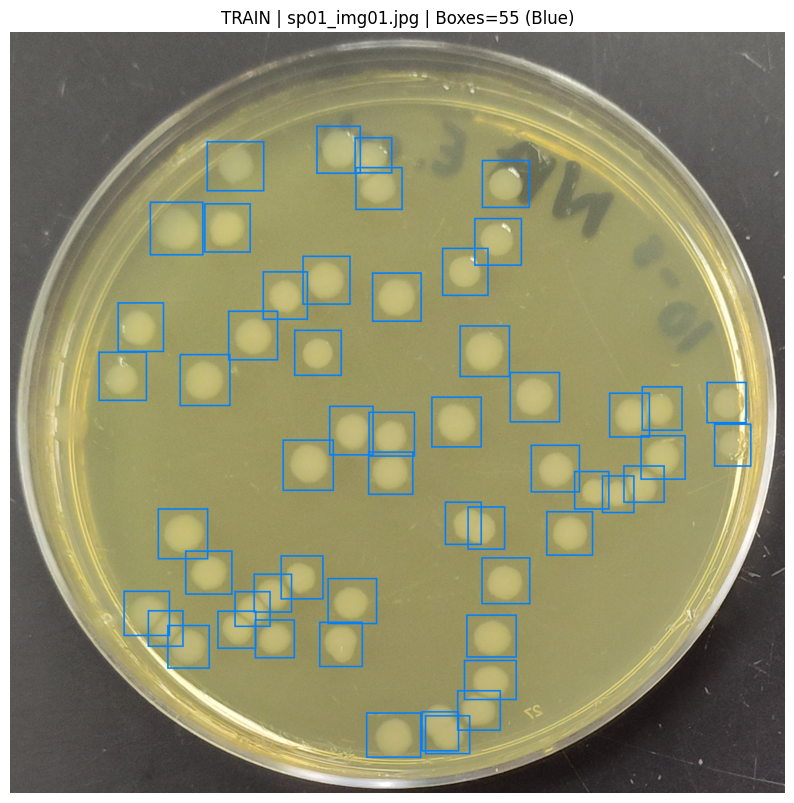

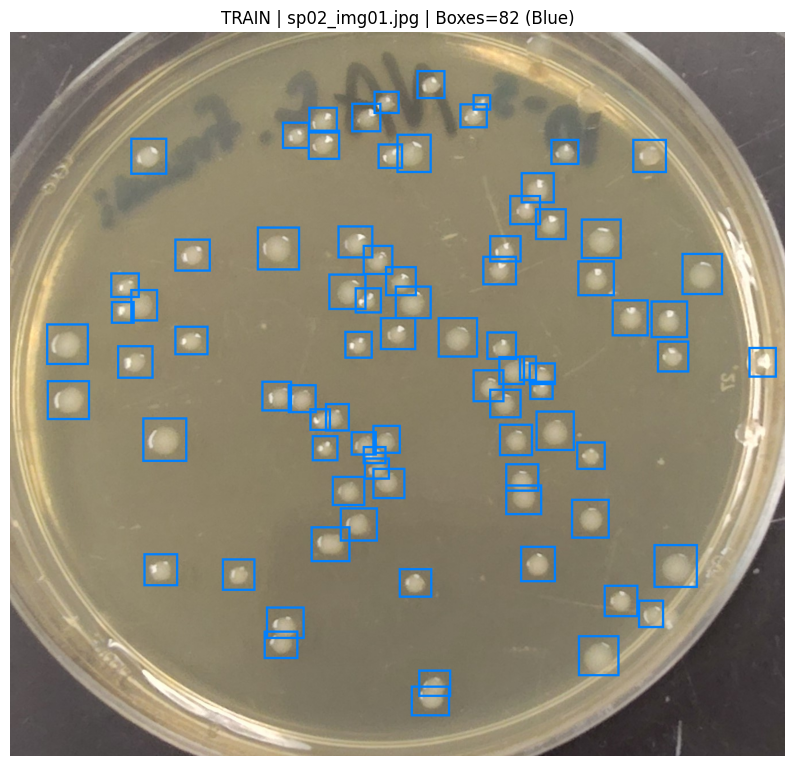

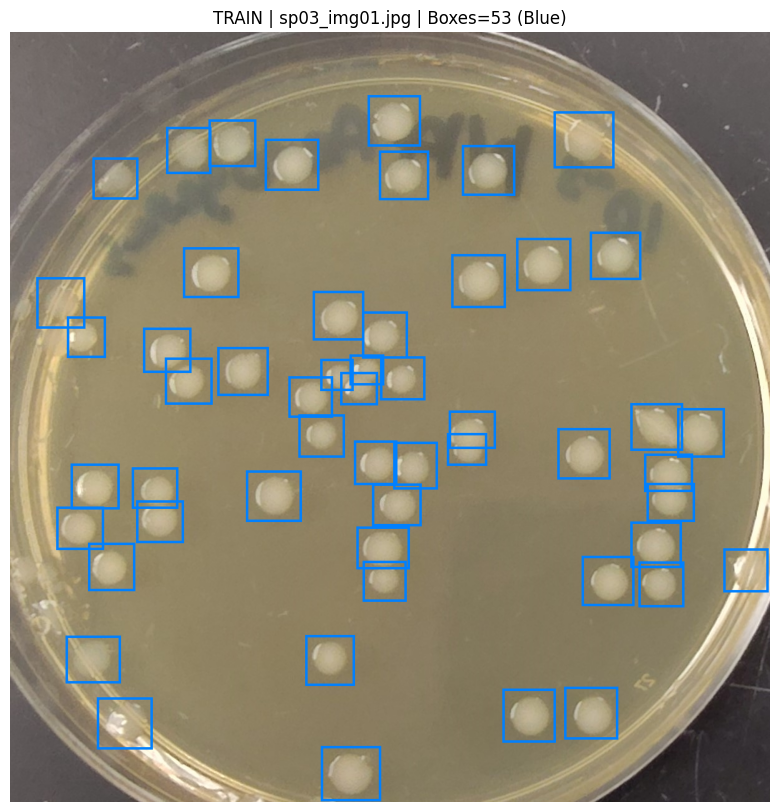

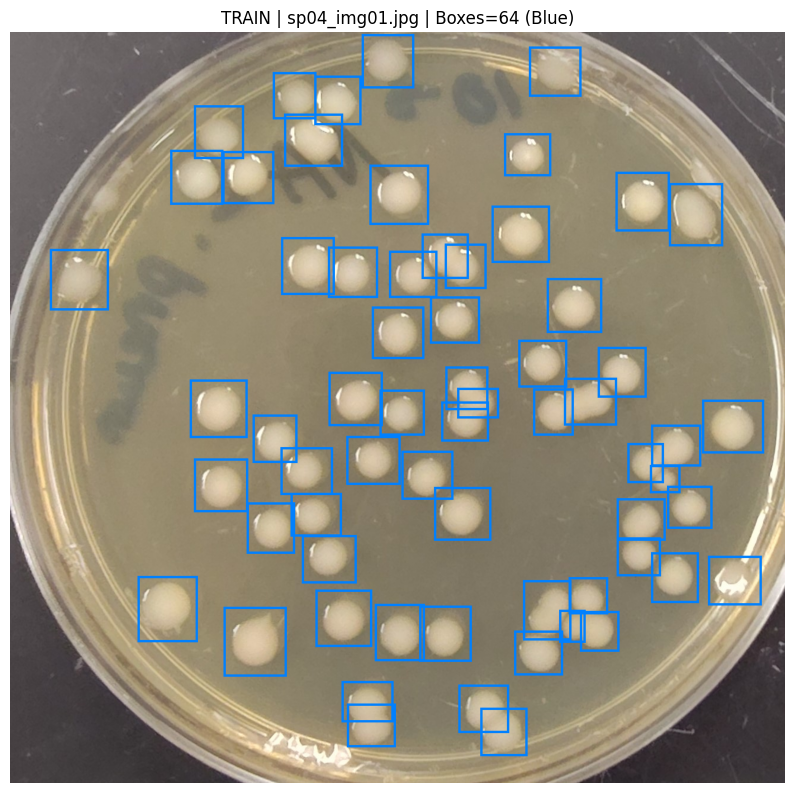


PLOTTING TEST IMAGES (TP=Green, FN=Yellow)
TEST images: 4 ['sp01_IMG_04_EC.jpg', 'sp02_IMG_02_CF_02.jpg', 'sp03_IMG_03_EA.jpg', 'sp04_IMG_02_KP.jpg']
⚠️ Missing TEST image: /content/drive/MyDrive/22022540/ground_truth/ground_truth_one/sp01_IMG_04_EC.jpg
⚠️ Missing TEST image: /content/drive/MyDrive/22022540/ground_truth/ground_truth_one/sp02_IMG_02_CF_02.jpg
⚠️ Missing TEST image: /content/drive/MyDrive/22022540/ground_truth/ground_truth_one/sp03_IMG_03_EA.jpg
⚠️ Missing TEST image: /content/drive/MyDrive/22022540/ground_truth/ground_truth_one/sp04_IMG_02_KP.jpg


In [ ]:
import os
import torch
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torchvision.models as models
import torch.nn as nn

# ---------------------------
# SETTINGS
# ---------------------------
FT_CKPT_PATH = os.path.join(WORKDIR_FINETUNE, "best_finetuned_on_newtest.pt")
PATCH_SIZE = globals().get("PATCH_SIZE", 100)

MARGIN_PIXELS = 0
MAX_IMAGES_TO_PLOT = None  # None = all

LINE_WIDTH_TRAIN = 4
LINE_WIDTH_TEST  = 4

# Colors
BLUE   = (0, 128, 255)   # TRAIN boxes
GREEN  = (0, 255, 0)     # TEST correct (TP)
YELLOW = (255, 255, 0)   # TEST wrong (FN)

# ---------------------------
# Checks
# ---------------------------
assert "train_df_ft" in globals(), "train_df_gt not found. Run your train/test split cell first."
assert "test_df_new" in globals(), "test_df_gt not found. Run your train/test split cell first."
assert "CLASSES_FT" in globals(), "CLASSES_FT not found."
assert "test_tf" in globals(), "test_tf not found."
assert "DEVICE" in globals(), "DEVICE not found."
assert os.path.exists(FT_CKPT_PATH), f"Missing checkpoint: {FT_CKPT_PATH}"

# ---------------------------
# Load model (best fine-tuned)
# ---------------------------
model_viz = models.resnet18(weights=None)
model_viz.fc = nn.Linear(model_viz.fc.in_features, len(CLASSES_FT))
model_viz.load_state_dict(torch.load(FT_CKPT_PATH, map_location=DEVICE))
model_viz = model_viz.to(DEVICE)
model_viz.eval()

# class mappings (must match training order)
class_to_idx = {c:i for i,c in enumerate(CLASSES_FT)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

# ---------------------------
# Helpers
# ---------------------------
def get_image_path_from_split_df(df_split, image_name: str):
    # Prefer stored full path if present
    if "image_path" in df_split.columns:
        row = df_split[df_split["image_name"].astype(str) == str(image_name)]
        if len(row) > 0:
            p = row["image_path"].dropna().astype(str).iloc[0]
            if os.path.exists(p):
                return p
    # Fallback
    return os.path.join(IMAGES_DIR_FT, str(image_name))

def crop_patch_vis(img_orig, x, y, w, h, margin=0):
    x1 = int(max(0, x - margin))
    y1 = int(max(0, y - margin))
    x2 = int(min(img_orig.size[0], x + w + margin))
    y2 = int(min(img_orig.size[1], y + h + margin))
    return img_orig.crop((x1, y1, x2, y2)).resize((PATCH_SIZE, PATCH_SIZE))

def preprocess_patch(pil_patch):
    return test_tf(pil_patch)

def plot_train_images_separately(train_df):
    train_images = sorted(train_df["image_name"].astype(str).unique().tolist())
    print("TRAIN images:", len(train_images), train_images)

    if MAX_IMAGES_TO_PLOT is not None:
        train_images = train_images[:MAX_IMAGES_TO_PLOT]

    for i, image_name in enumerate(train_images, start=1):
        df_img = train_df[train_df["image_name"].astype(str) == image_name].copy().reset_index(drop=True)
        img_path = get_image_path_from_split_df(train_df, image_name)
        if not os.path.exists(img_path):
            print("⚠️ Missing TRAIN image:", img_path)
            continue

        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        for _, r in df_img.iterrows():
            x = float(r["bbox_x"]); y = float(r["bbox_y"])
            w = float(r["bbox_width"]); h = float(r["bbox_height"])
            draw.rectangle([x, y, x+w, y+h], outline=BLUE, width=LINE_WIDTH_TRAIN)

        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"TRAIN | {image_name} | Boxes={len(df_img)} (Blue)")
        plt.show()

def plot_test_images_separately(test_df):
    test_images = sorted(test_df["image_name"].astype(str).unique().tolist())
    print("TEST images:", len(test_images), test_images)

    if MAX_IMAGES_TO_PLOT is not None:
        test_images = test_images[:MAX_IMAGES_TO_PLOT]

    for i, image_name in enumerate(test_images, start=1):
        df_img = test_df[test_df["image_name"].astype(str) == image_name].copy().reset_index(drop=True)
        img_path = get_image_path_from_split_df(test_df, image_name)
        if not os.path.exists(img_path):
            print("⚠️ Missing TEST image:", img_path)
            continue

        img_orig = Image.open(img_path).convert("RGB")
        img_draw = img_orig.copy()
        draw = ImageDraw.Draw(img_draw)

        # Build batch
        xs = []
        meta = []  # (x,y,w,h,true_label)
        for _, r in df_img.iterrows():
            x = float(r["bbox_x"]); y = float(r["bbox_y"])
            w = float(r["bbox_width"]); h = float(r["bbox_height"])
            true_name = str(r["label_name"])

            patch = crop_patch_vis(img_orig, x, y, w, h, margin=MARGIN_PIXELS)
            xs.append(preprocess_patch(patch))
            meta.append((x, y, w, h, true_name))

        if len(xs) > 0:
            X = torch.stack(xs).to(DEVICE)
            with torch.no_grad():
                logits = model_viz(X)
                y_pred = logits.argmax(dim=1).cpu().numpy()

            for (x, y, w, h, true_name), pred_idx in zip(meta, y_pred):
                pred_name = idx_to_class[int(pred_idx)]
                color = GREEN if pred_name == true_name else YELLOW
                draw.rectangle([x, y, x+w, y+h], outline=color, width=LINE_WIDTH_TEST)
                draw.text((x+2, y+2), f"{true_name}->{pred_name}", fill=color)

        plt.figure(figsize=(10, 10))
        plt.imshow(img_draw)
        plt.axis("off")
        plt.title(f"TEST | {image_name} | Green=TP Yellow=FN | Boxes={len(df_img)}")
        plt.show()

# ---------------------------
# RUN: plot TRAIN and TEST separately
# ---------------------------
print("\n====================")
print("PLOTTING TRAIN IMAGES (Blue boxes)")
print("====================")
plot_train_images_separately(train_df_ft)

print("\n====================")
print("PLOTTING TEST IMAGES (TP=Green, FN=Yellow)")
print("====================")
plot_test_images_separately(test_df_new)
